In [620]:
%matplotlib inline
import io
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pymongo
from pymongo import MongoClient
from __future__ import division
from pprint import pprint
import operator
from texttable import Texttable

In [594]:
# Connecting to mongoDB database
client = pymongo.MongoClient()
db = client['RiotMongoDB']

SummonerID_Collection = db["SummonerID"]
GamesStats_Collection = db["GamesStats"]
ChampionMastery_Collection = db["ChampionMastery"]
ChampionCount_Collection = db["ChampionCount"]

In [602]:
sumdir = glob.glob("Summoner/*.json")

for item in sumdir:
    with io.open(item , 'r', encoding='utf-8') as json_data:
        summoner = json.load(json_data)
        json_data.close()
    entryID = SummonerID_Collection.insert_one({'_id':summoner['_id'], 'name':summoner['name'], 'summonerLevel':summoner['summonerLevel']})

In [596]:
sumdir = glob.glob("RecentHistory/*.json")

for item in sumdir:
    with io.open(item , 'r', encoding='utf-8') as json_data:
        history = json.load(json_data)
        json_data.close()
    for i in range(len(history['games'])):
        entryID = GamesStats_Collection.insert_one({'id':history['_id'], 'games':history['games'][i]})

# Query Part

* Make a sample query using find_one()

* Find some things by specifying something

* Count

* Advanced Query and Sort

In [661]:
# Get the names for all the current databases
db.collection_names()

[u'ChampionCount', u'GamesStats', u'SummonerID']

In [604]:
# Get a single sample document
SummonerID_Collection.find_one()

{u'_id': 102363, u'name': u'Twitch DiabloEMT', u'summonerLevel': 30}

In [605]:
# Conduct a simple 'count' query
SummonerID_Collection.count("_id")

32660

In [606]:
# Count the frequency of each champion using aggregation pipeline
for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group" : {"_id" : {'championId':"$games.championId",'win':"$games.stats.win"}, "frequency" : {"$sum" : 1}}}]):
    entryID = ChampionCount_Collection.insert_one(item)
    
# Count the frequency of each champion considering the summoners' fellow players    
for item in GamesStats_Collection.aggregate([{"$unwind": "$games.fellowPlayers"},
                                             {"$group" : {"_id" : {'championId':"$games.fellowPlayers.championId",
                                                                   'win': { "$cond": [ { "$eq": [ "$games.fellowPlayers.teamId", "$games.teamId" ] } , "$games.stats.win", {"$not":["$games.stats.win"]} ]}
                                                                  }, "frequency" : {"$sum" : 1}}}]):
    if GamesStats_Collection.find({"_id":item["_id"]}) > 0:
        for node in GamesStats_Collection.find({"_id":item["_id"]}):
            node['frequency'] += item['frequency']
    else:
        entryID = ChampionCount_Collection.insert_one(item)

In [607]:
for item in ChampionCount_Collection.find():
    print item

{u'_id': {u'win': False, u'championId': 72}, u'frequency': 327}
{u'_id': {u'win': False, u'championId': 163}, u'frequency': 399}
{u'_id': {u'win': True, u'championId': 14}, u'frequency': 798}
{u'_id': {u'win': False, u'championId': 127}, u'frequency': 567}
{u'_id': {u'win': False, u'championId': 268}, u'frequency': 544}
{u'_id': {u'win': True, u'championId': 82}, u'frequency': 355}
{u'_id': {u'win': True, u'championId': 34}, u'frequency': 616}
{u'_id': {u'win': True, u'championId': 33}, u'frequency': 598}
{u'_id': {u'win': False, u'championId': 19}, u'frequency': 560}
{u'_id': {u'win': False, u'championId': 254}, u'frequency': 1428}
{u'_id': {u'win': False, u'championId': 92}, u'frequency': 1854}
{u'_id': {u'win': False, u'championId': 86}, u'frequency': 838}
{u'_id': {u'win': True, u'championId': 89}, u'frequency': 1736}
{u'_id': {u'win': False, u'championId': 8}, u'frequency': 684}
{u'_id': {u'win': False, u'championId': 34}, u'frequency': 661}
{u'_id': {u'win': False, u'championId':

In [608]:
# Calculate the win-rate of each champion
winrate = {}
popularity = {}
for item in ChampionCount_Collection.aggregate([{"$unwind": "$_id"},
                                                {"$group": {"_id": '$_id.championId',
                                                 'total': {"$sum": "$frequency"},
                                                 'win': {"$sum": { "$cond": [ { "$eq": [ "$_id.win", True ] } , "$frequency", 0 ]}}}}]):
    Id = item['_id']
    winrate.update({Id:item['win']/item['total']})
    popularity.update({Id:item['total']})

In [628]:
t = Texttable()
t.add_row(['ChampionId', 'win-rate'])

sorted_winrate = sorted(winrate.items(), key=operator.itemgetter(1), reverse=True)

for i in range(5):
    t.add_row([sorted_winrate[i][0], sorted_winrate[i][1]])
    
print t.draw()

+------------+----------+
| ChampionId | win-rate |
+------------+----------+
| 3          | 0.614    |
+------------+----------+
| 37         | 0.583    |
+------------+----------+
| 115        | 0.583    |
+------------+----------+
| 96         | 0.576    |
+------------+----------+
| 14         | 0.575    |
+------------+----------+


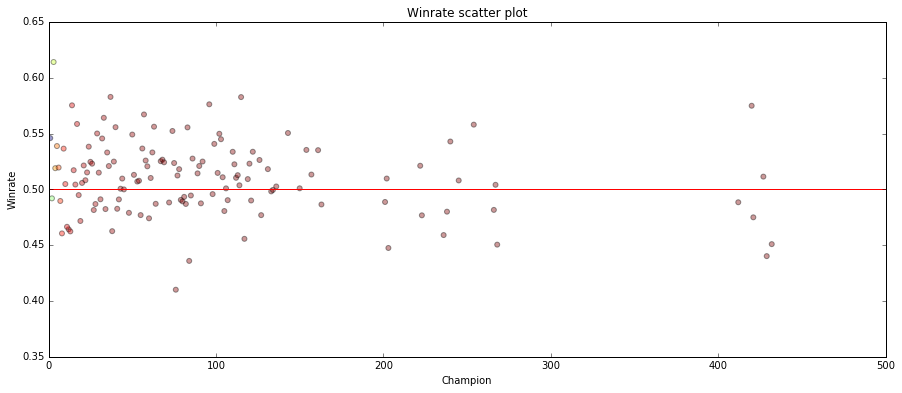

In [613]:
plt.figure(figsize=(15,6))
T=np.arctan2(winrate.keys(),winrate.values())
plt.scatter(winrate.keys(),winrate.values(),c=T,s=25,alpha=0.4,marker='o')
plt.axhline(y=.5, xmin=0, xmax=500, linewidth=1, color = 'r')
plt.xlim([0,500])
plt.title("Winrate scatter plot")
plt.xlabel("Champion")
plt.ylabel("Winrate")
plt.show()

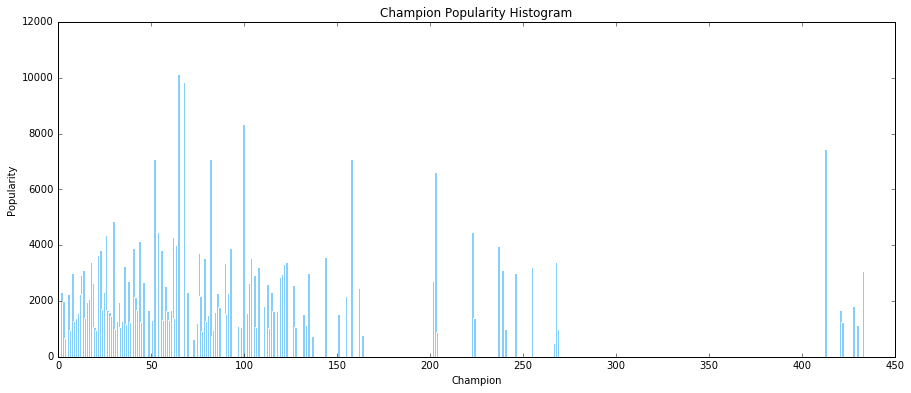

In [615]:
X = popularity.keys()
Y = popularity.values()
plt.figure(figsize=(15,6))
plt.bar(X,Y,width = 1.5,facecolor = 'lightskyblue',edgecolor = 'white')

plt.title("Champion Popularity Histogram")
plt.xlabel("Champion")
plt.ylabel("Popularity")
plt.show()

In [629]:
# Count the frequency of each champion using aggregation pipeline
wrolefreq = []
wrole1 = {}
wrole2 = {}
wrole3 = {}
wrole4 = {}
wrolefreq = [wrole1,wrole2,wrole3,wrole4]

lrolefreq = []
lrole1 = {}
lrole2 = {}
lrole3 = {}
lrole4 = {}
lrolefreq = [lrole1,lrole2,lrole3,lrole4]

for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group" : {"_id" : {'championId':"$games.championId",'role':"$games.stats.playerRole",'win':"$games.stats.win"}, "frequency" : {"$sum" : 1}}}]):
    if "role" not in item["_id"].keys():
        continue
    if item["_id"]["win"] is True:
        wrolefreq[item["_id"]["role"]-1].update({item["_id"]["championId"]:item["frequency"]})
        continue
    if item["_id"]["win"] is False:
        lrolefreq[item["_id"]["role"]-1].update({item["_id"]["championId"]:item["frequency"]})

In [630]:
win = []
win1 = {}
win2 = {}
win3 = {}
win4 = {}
win = [win1,win2,win3,win4]

for i in range(4):
    for champ in wrolefreq[i].keys():
        if champ not in lrolefreq[i].keys():
            win[i].update({champ:1})
        else:
            rate = wrolefreq[i][champ]/(wrolefreq[i][champ]+lrolefreq[i][champ])
            win[i].update({champ:rate})
    for champ in lrolefreq[i].keys():
        if champ not in wrolefreq[i].keys():
            win[i].update({champ:0})

In [665]:
print win

[{1: 0.5961538461538461, 2: 0.5294117647058824, 3: 0.4666666666666667, 4: 0.5257731958762887, 5: 0.6376811594202898, 6: 0.45652173913043476, 7: 0.49732620320855614, 8: 0.4675324675324675, 9: 0.5, 10: 0.5892857142857143, 267: 0.36363636363636365, 12: 0.3142857142857143, 13: 0.5069124423963134, 14: 0.5147058823529411, 15: 0.4418604651162791, 16: 0.47368421052631576, 17: 0.5125, 18: 0.5612244897959183, 19: 0.375, 20: 0.6666666666666666, 21: 0.5241379310344828, 22: 0.5454545454545454, 23: 0.5263157894736842, 24: 0.5797101449275363, 25: 0.5476190476190477, 26: 0.4523809523809524, 27: 0.5241935483870968, 28: 0.2857142857142857, 29: 0.5251396648044693, 30: 0.675, 31: 0.463768115942029, 32: 0.35714285714285715, 33: 0.5277777777777778, 34: 0.5483870967741935, 35: 0.5520833333333334, 36: 0.5641025641025641, 37: 0.4358974358974359, 38: 0.4166666666666667, 39: 0.5476190476190477, 40: 0.7142857142857143, 41: 0.5288461538461539, 42: 0.5151515151515151, 43: 0.5433070866141733, 44: 0.375, 45: 0.535031

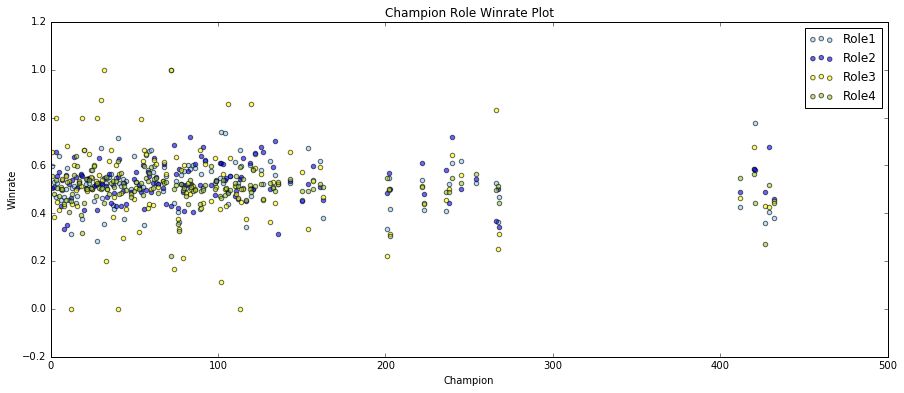

In [673]:
plt.figure(figsize=(15,6))
plt.scatter(win[0].keys(),win[0].values(),c = 'lightskyblue',alpha=0.6,label = 'Role1')
plt.scatter(win[1].keys(),win[1].values(),c = 'blue',alpha=0.6,label = 'Role2')
plt.scatter(win[2].keys(),win[2].values(),c = 'yellow',alpha=0.6,label = 'Role3')
plt.scatter(win[3].keys(),win[3].values(),c = 'yellowgreen',alpha=0.6,label = 'Role4')
plt.xlim([0,500])
plt.title("Champion Role Winrate Plot")
plt.xlabel("Champion")
plt.ylabel("Winrate")
plt.legend()
plt.show()

In [632]:
# Count the frequency of each champion group by role using aggregation pipeline
rolefreq = []
role1 = {}
role2 = {}
role3 = {}
role4 = {}
rolefreq = [role1,role2,role3,role4]

for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group" : {"_id" : {'championId':"$games.championId",'role':"$games.stats.playerRole"}, "frequency" : {"$sum" : 1}}}]):
    if "role" in item["_id"].keys():
        rolefreq[item["_id"]["role"]-1].update({item["_id"]["championId"]:item["frequency"]})

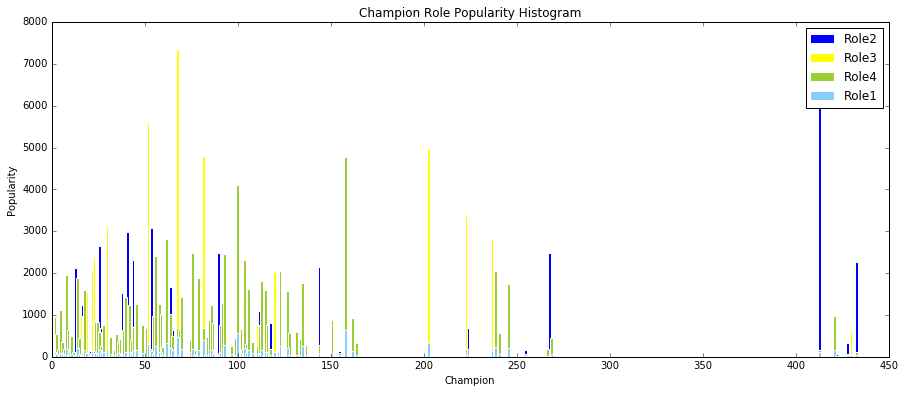

In [634]:
# Plot popularity according to roles
plt.figure(figsize=(15,6))
#plt.bar(rolefreq[0].keys(),rolefreq[0].values(),width = 1.5,facecolor = 'lightskyblue',edgecolor = 'white',label = 'Role1')
plt.bar(rolefreq[1].keys(),rolefreq[1].values(),width = 1.5,facecolor = 'blue',edgecolor = 'white',label = 'Role2')
plt.bar(rolefreq[2].keys(),rolefreq[2].values(),width = 1.5,facecolor = 'yellow',edgecolor = 'white',label = 'Role3')
plt.bar(rolefreq[3].keys(),rolefreq[3].values(),width = 1.5,facecolor = 'yellowgreen',edgecolor = 'white',label = 'Role4')
plt.bar(rolefreq[0].keys(),rolefreq[0].values(),width = 1.5,facecolor = 'lightskyblue',edgecolor = 'white',label = 'Role1')
plt.title("Champion Role Popularity Histogram")
plt.xlabel("Champion")
plt.ylabel("Popularity")
plt.legend()
plt.show()

In [ ]:
# See the mean and variance of some statics, sort
# Game impact & damage dealt

In [637]:
from texttable import Texttable
t = Texttable()
t.add_row(['ChampionId', 'avgassists'])
assist = {}

for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group": {"_id": '$games.championId',
                                              'avgassists': {"$avg": "$games.stats.assists"}}},
                                             {"$sort": {'avgassists': -1}}]):
    t.add_row([item['_id'], item['avgassists']])
    assist.update({item['_id']:item['avgassists']}) 
    
print t.draw()

+------------+------------+
| ChampionId | avgassists |
+------------+------------+
| 3          | 21.139     |
+------------+------------+
| 37         | 20.588     |
+------------+------------+
| 16         | 20.295     |
+------------+------------+
| 44         | 20.187     |
+------------+------------+
| 267        | 19.325     |
+------------+------------+
| 40         | 19.182     |
+------------+------------+
| 201        | 18.040     |
+------------+------------+
| 20         | 17.864     |
+------------+------------+
| 9          | 17.697     |
+------------+------------+
| 117        | 17.617     |
+------------+------------+
| 26         | 17.106     |
+------------+------------+
| 30         | 16.987     |
+------------+------------+
| 98         | 16.745     |
+------------+------------+
| 89         | 16.636     |
+------------+------------+
| 59         | 16.474     |
+------------+------------+
| 412        | 16.312     |
+------------+------------+
| 12         | 16.21

In [674]:
t = Texttable()
t.add_row(['ChampionId', 'avgdeaths'])
deaths = {}
for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group": {"_id": '$games.championId',
                                              'avgnumDeaths': {"$avg": "$games.stats.numDeaths"}}},
                                              {"$sort": {'avgnumDeaths': 1}}]):
    t.add_row([item['_id'], item['avgnumDeaths']])
    deaths.update({item['_id']:item['avgnumDeaths']})
print t.draw()

+------------+-----------+
| ChampionId | avgdeaths |
+------------+-----------+
| 40         | 5.167     |
+------------+-----------+
| 154        | 5.822     |
+------------+-----------+
| 427        | 5.912     |
+------------+-----------+
| 267        | 6.031     |
+------------+-----------+
| 102        | 6.190     |
+------------+-----------+
| 78         | 6.195     |
+------------+-----------+
| 16         | 6.263     |
+------------+-----------+
| 98         | 6.352     |
+------------+-----------+
| 111        | 6.382     |
+------------+-----------+
| 99         | 6.402     |
+------------+-----------+
| 120        | 6.419     |
+------------+-----------+
| 81         | 6.584     |
+------------+-----------+
| 72         | 6.603     |
+------------+-----------+
| 57         | 6.644     |
+------------+-----------+
| 201        | 6.648     |
+------------+-----------+
| 44         | 6.655     |
+------------+-----------+
| 412        | 6.694     |
+------------+-----------+
|

In [645]:
totaldamage = {}
for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group": {"_id": '$games.championId',
                                              'avgtotalDamage': {"$avg": "$games.stats.totalDamageDealt"}}},
                                              {"$sort": {'avgtotalDamage': -1}}]):
    print item
    totaldamage.update({item['_id']:item['avgtotalDamage']})  

{u'avgtotalDamage': 247637.7903930131, u'_id': 427}
{u'avgtotalDamage': 194940.01927597556, u'_id': 41}
{u'avgtotalDamage': 170112.8109227872, u'_id': 102}
{u'avgtotalDamage': 165973.50995316159, u'_id': 23}
{u'avgtotalDamage': 163877.46738058334, u'_id': 157}
{u'avgtotalDamage': 160333.43846045397, u'_id': 51}
{u'avgtotalDamage': 155850.2486809708, u'_id': 104}
{u'avgtotalDamage': 152654.59564541213, u'_id': 107}
{u'avgtotalDamage': 152607.8286151492, u'_id': 56}
{u'avgtotalDamage': 147211.25466586393, u'_id': 420}
{u'avgtotalDamage': 146964.47171082173, u'_id': 222}
{u'avgtotalDamage': 145371.489067426, u'_id': 67}
{u'avgtotalDamage': 144968.79747515445, u'_id': 75}
{u'avgtotalDamage': 144868.02811791384, u'_id': 202}
{u'avgtotalDamage': 143656.52911392404, u'_id': 15}
{u'avgtotalDamage': 141616.95115143058, u'_id': 119}
{u'avgtotalDamage': 141224.34932194877, u'_id': 236}
{u'avgtotalDamage': 139787.44146341464, u'_id': 115}
{u'avgtotalDamage': 139122.72719819634, u'_id': 29}
{u'avgt

In [653]:
print totaldamage

{1: 89002.55023514322, 2: 126274.35406218655, 3: 100387.07511045656, 4: 121011.5096196868, 5: 124625.47291296626, 6: 84578.5216931217, 7: 98836.16192706591, 8: 106443.5260252366, 9: 97095.63512544803, 266: 117730.4306122449, 11: 135384.12052980132, 268: 105866.57330637008, 13: 133573.29948253557, 14: 105201.42826243691, 15: 143656.52911392404, 16: 29675.43924783028, 17: 117985.37622005324, 18: 126949.07990953638, 19: 86917.77525967894, 20: 85520.06038135593, 21: 118650.18999175144, 22: 121564.3504697286, 23: 165973.50995316159, 24: 124089.80628497632, 25: 60280.68580615526, 26: 77083.58545239503, 27: 120620.06199123357, 28: 118691.54941257775, 29: 139122.72719819634, 30: 124013.37913741224, 31: 112412.93827160494, 32: 103746.28498467825, 33: 95127.88490566038, 34: 105884.06421299922, 35: 113921.3560209424, 36: 102329.16424294269, 37: 41122.19138755981, 38: 85057.9673046252, 39: 111865.22161172162, 40: 23338.172007177647, 41: 194940.01927597556, 42: 117377.99581589959, 43: 61405.0200676

In [640]:
for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group": {"_id": '$games.championId',
                                              'avgtotalDamage': {"$avg": "$games.stats.totalDamageDealt"}}},
                                              {"$sort": {'avgtotalDamage': -1}}]):
    print item

{u'avgtotalDamage': 247637.7903930131, u'_id': 427}
{u'avgtotalDamage': 194940.01927597556, u'_id': 41}
{u'avgtotalDamage': 170112.8109227872, u'_id': 102}
{u'avgtotalDamage': 165973.50995316159, u'_id': 23}
{u'avgtotalDamage': 163877.46738058334, u'_id': 157}
{u'avgtotalDamage': 160333.43846045397, u'_id': 51}
{u'avgtotalDamage': 155850.2486809708, u'_id': 104}
{u'avgtotalDamage': 152654.59564541213, u'_id': 107}
{u'avgtotalDamage': 152607.8286151492, u'_id': 56}
{u'avgtotalDamage': 147211.25466586393, u'_id': 420}
{u'avgtotalDamage': 146964.47171082173, u'_id': 222}
{u'avgtotalDamage': 145371.489067426, u'_id': 67}
{u'avgtotalDamage': 144968.79747515445, u'_id': 75}
{u'avgtotalDamage': 144868.02811791384, u'_id': 202}
{u'avgtotalDamage': 143656.52911392404, u'_id': 15}
{u'avgtotalDamage': 141616.95115143058, u'_id': 119}
{u'avgtotalDamage': 141224.34932194877, u'_id': 236}
{u'avgtotalDamage': 139787.44146341464, u'_id': 115}
{u'avgtotalDamage': 139122.72719819634, u'_id': 29}
{u'avgt

In [641]:
magicdamage = {}
for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group": {"_id": '$games.championId',
                                              'avgMagicDamage1': {"$avg": "$games.stats.magicDamageDealtToChampions"},
                                              'avgMagicDamage2': {"$avg": "$games.stats.magicDamageDealtPlayer"}}},
                                             {"$project":{"_id": 1,
                                                          "avgMagicDamage":{"$add":['$avgMagicDamage1','$avgMagicDamage2']}}},
                                             {"$sort": {'avgMagicDamage': -1}}]):
    print item
    if item['avgMagicDamage'] is None:
        continue
    magicdamage.update({item['_id']:item['avgMagicDamage']})   

{u'avgMagicDamage': 154227.99911392468, u'_id': 30}
{u'avgMagicDamage': 153855.98841463414, u'_id': 115}
{u'avgMagicDamage': 151578.46361185983, u'_id': 112}
{u'avgMagicDamage': 143628.95698255516, u'_id': 134}
{u'avgMagicDamage': 142499.6998784863, u'_id': 13}
{u'avgMagicDamage': 141203.94025849958, u'_id': 45}
{u'avgMagicDamage': 136178.65256036172, u'_id': 101}
{u'avgMagicDamage': 135082.38890405066, u'_id': 68}
{u'avgMagicDamage': 134553.01312964628, u'_id': 27}
{u'avgMagicDamage': 130177.5553742131, u'_id': 61}
{u'avgMagicDamage': 126439.06457564575, u'_id': 127}
{u'avgMagicDamage': 126159.12376039824, u'_id': 55}
{u'avgMagicDamage': 125843.88822654248, u'_id': 69}
{u'avgMagicDamage': 124842.32142857142, u'_id': 131}
{u'avgMagicDamage': 123364.36810445535, u'_id': 99}
{u'avgMagicDamage': 123312.71231297523, u'_id': 136}
{u'avgMagicDamage': 121900.38713396182, u'_id': 4}
{u'avgMagicDamage': 120634.73365805864, u'_id': 245}
{u'avgMagicDamage': 119470.82082973898, u'_id': 74}
{u'avgM

In [642]:
physicaldamage = {}
for item in GamesStats_Collection.aggregate([{"$unwind": "$games"},
                                             {"$group": {"_id": '$games.championId',
                                              'avgPhysicalDamage1': {"$avg": "$games.stats.physicalDamageDealtToChampions"},
                                              'avgPhysicalDamage2': {"$avg": "$games.stats.physicalDamageDealtPlayer"}}},
                                             {"$project":{"_id": 1,
                                                          "avgPhysicalDamage":{"$add":['$avgPhysicalDamage1','$avgPhysicalDamage2']}}},
                                             {"$sort": {'avgPhysicalDamage': -1}}]):
    if item['avgPhysicalDamage'] is None:
        continue
    physicaldamage.update({item['_id']:item['avgPhysicalDamage']})

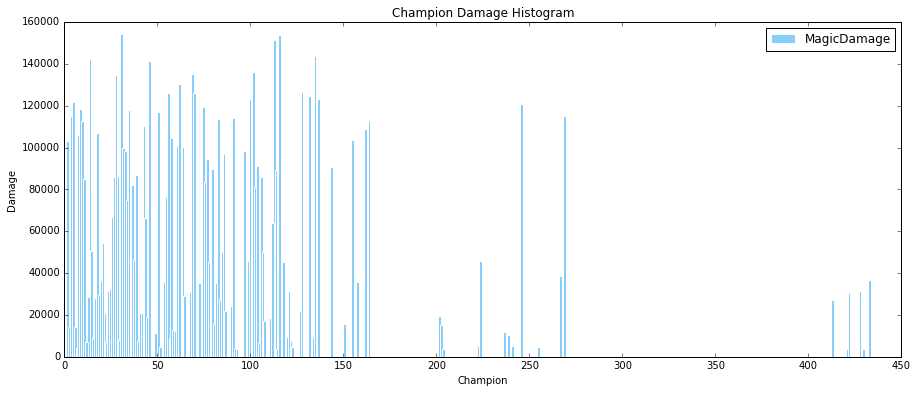

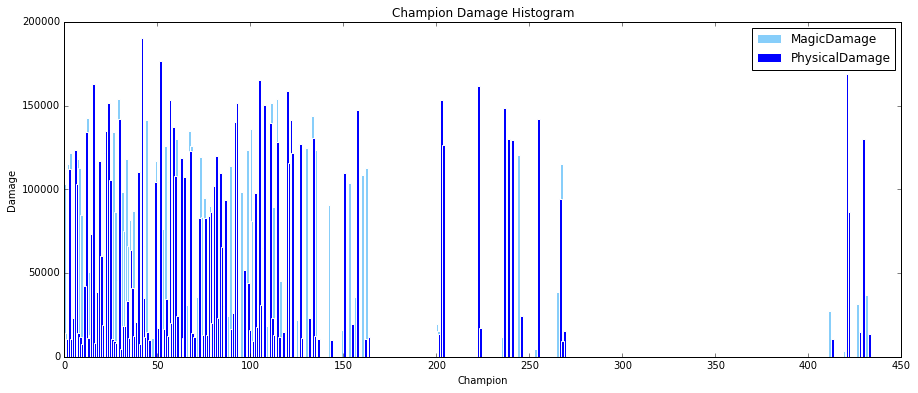

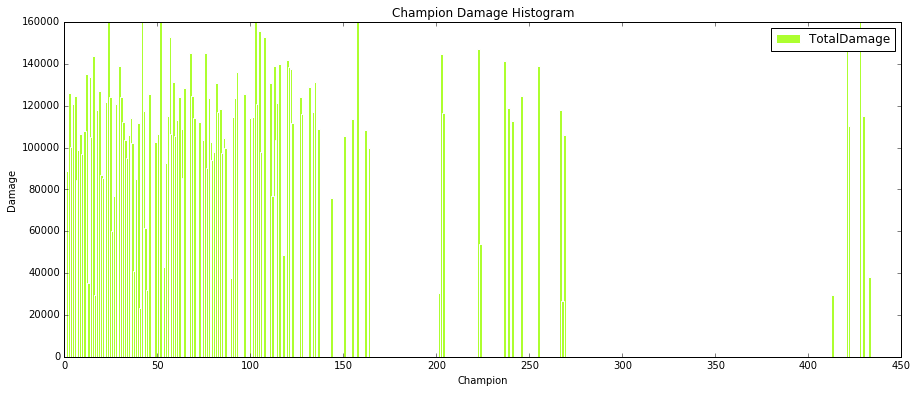

In [677]:
plt.figure(figsize=(15,6))
plt.bar([i-1.5 for i in magicdamage.keys()],magicdamage.values(),width = 1.5,facecolor = 'lightskyblue',edgecolor = 'white',label = 'MagicDamage')
plt.bar(physicaldamage.keys(),physicaldamage.values(),width = 1.5,facecolor = 'blue',edgecolor = 'white',label = 'PhysicalDamage')
plt.xlim([0,450])
plt.title("Champion Damage Histogram")
plt.xlabel("Champion")
plt.ylabel("Damage")
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
plt.bar(totaldamage.keys(),totaldamage.values(),width = 1.5,facecolor = 'greenyellow',edgecolor = 'white',label = 'TotalDamage')
plt.ylim([0,160000])
plt.title("Champion Damage Histogram")
plt.xlabel("Champion")
plt.ylabel("Damage")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(magicdamage.keys(),magicdamage.values(),width = 1.5,facecolor = 'lightskyblue',edgecolor = 'white',label = 'MagicDamage')
plt.bar(physicaldamage.keys(),physicaldamage.values(),width = 1.5,facecolor = 'blue',edgecolor = 'white',label = 'PhysicalDamage')
#plt.bar(totaldamage.keys(),totaldamage.values(),width = 1.5,facecolor = 'greenyellow',edgecolor = 'white',label = 'TotalDamage')

plt.title("Champion Damage Histogram")
plt.xlabel("Champion")
plt.ylabel("Damage")
plt.legend()
plt.show()

In [531]:
# Count the frequency of each champion using map reduce

from bson.code import Code
reducer = Code("""
                function(obj, prev){
                  prev.count++;
                }
                """)

results = ChampionMastery_Collection.group(key={"championId":1}, condition={}, initial={"count": 0}, reduce=reducer)
for doc in results:
    print doc

{u'count': 5.0, u'championId': 157.0}
{u'count': 5.0, u'championId': 51.0}
{u'count': 4.0, u'championId': 222.0}
{u'count': 3.0, u'championId': 202.0}
{u'count': 5.0, u'championId': 412.0}
{u'count': 4.0, u'championId': 67.0}
{u'count': 5.0, u'championId': 81.0}
{u'count': 5.0, u'championId': 64.0}
{u'count': 3.0, u'championId': 103.0}
{u'count': 4.0, u'championId': 84.0}
{u'count': 3.0, u'championId': 119.0}
{u'count': 4.0, u'championId': 245.0}
{u'count': 5.0, u'championId': 102.0}
{u'count': 5.0, u'championId': 122.0}
{u'count': 5.0, u'championId': 22.0}
{u'count': 5.0, u'championId': 150.0}
{u'count': 4.0, u'championId': 429.0}
{u'count': 3.0, u'championId': 201.0}
{u'count': 5.0, u'championId': 29.0}
{u'count': 3.0, u'championId': 238.0}
{u'count': 5.0, u'championId': 114.0}
{u'count': 4.0, u'championId': 4.0}
{u'count': 4.0, u'championId': 18.0}
{u'count': 3.0, u'championId': 21.0}
{u'count': 4.0, u'championId': 15.0}
{u'count': 3.0, u'championId': 14.0}
{u'count': 4.0, u'champio

In [ ]:
client.close()